In [112]:
import os
os.chdir("C:/Users/Yatri/Desktop/COVID19")

<p style="text-align: center;"><font size=5><b>Visualizing COVID19</b></font></p>

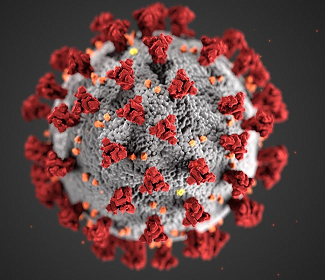

In [113]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import requests
from datetime import datetime

In [114]:
# sending a HTTP request to a web service to pull data
raw_data = requests.get("https://services1.arcgis.com/0MSEUqKaxRlEPj5g/arcgis/rest/services/Coronavirus_2019_nCoV_Cases/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json")
raw_json = raw_data.json()
df = pd.DataFrame(raw_json["features"])
df.head()

,attributes,geometry
0,"{'OBJECTID': 1, 'Province_State': 'Abruzzo', '...","{'x': 13.398438230000068, 'y': 42.35122196000003}"
1,"{'OBJECTID': 2, 'Province_State': 'Acre', 'Cou...","{'x': -70.81199999999995, 'y': -9.023799999999..."
2,"{'OBJECTID': 3, 'Province_State': 'Aguascalien...","{'x': -102.29159999999996, 'y': 21.88530000000..."
3,"{'OBJECTID': 4, 'Province_State': 'Aichi', 'Co...","{'x': 137.21162100000004, 'y': 35.035551000000..."
4,"{'OBJECTID': 5, 'Province_State': 'Akita', 'Co...","{'x': 140.408228, 'y': 39.74867900000004}"


In [115]:
df["attributes"][0]
# trannsforming attributes structured as a list of dictionaries to pandas dataframe
data_list = df["attributes"].tolist()
df_final = pd.DataFrame(data_list)
# setting OBJECTID attribute as an index
df_final.set_index("OBJECTID")
df_final = df_final[["Province_State","Country_Region","Last_Update","Lat","Long_","Confirmed","Recovered","Deaths"]]
df_final.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Recovered,Deaths
0,Abruzzo,Italy,1.591040e+12,42.351222,13.398438,3245,2093,408
1,Acre,Brazil,1.591040e+12,-9.023800,-70.812000,6219,0,148
2,Aguascalientes,Mexico,1.591040e+12,21.885300,-102.291600,816,574,35
3,Aichi,Japan,1.591040e+12,35.035551,137.211621,507,457,34
4,Akita,Japan,1.591040e+12,39.748679,140.408228,16,16,0


In [116]:
# finding number of missing values from each column
null_columns=df_final.columns[df_final.isnull().any()]
df_final[null_columns].isnull().sum()

Province_State    175
Last_Update         2
Lat                11
Long_              11
dtype: int64

In [117]:
# defining a function to convert timestamp to date format
def convertTime(t):
    t = int(t)
    return datetime.fromtimestamp(t)

# removing missing values from column Last_Update
df_final = df_final.dropna(subset=["Last_Update"])

# replacing missing values in columns by an empty string
df_final["Province_State"].fillna(value="", inplace=True)
df_final["Lat"].fillna(value="",inplace=True)
df_final["Long_"].fillna(value="",inplace=True)

# converting timestamp into date format
df_final["Last_Update"]= df_final["Last_Update"]/1000
df_final["Last_Update"] = df_final["Last_Update"].apply(convertTime)

In [118]:
df_final.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Recovered,Deaths
0,Abruzzo,Italy,2020-06-01 15:32:47,42.3512,13.3984,3245,2093,408
1,Acre,Brazil,2020-06-01 15:32:47,-9.0238,-70.812,6219,0,148
2,Aguascalientes,Mexico,2020-06-01 15:32:47,21.8853,-102.292,816,574,35
3,Aichi,Japan,2020-06-01 15:32:47,35.0356,137.212,507,457,34
4,Akita,Japan,2020-06-01 15:32:47,39.7487,140.408,16,16,0


In [119]:
#Performing data aggregation by each country
df_total = df_final.groupby("Country_Region", as_index=False).agg(
    {
        "Confirmed":"sum",
        "Deaths":"sum",
        "Recovered":"sum"
    }
)
df_total.head()

,Country_Region,Confirmed,Deaths,Recovered
0,Afghanistan,15750,265,1428
1,Albania,1143,33,877
2,Algeria,9513,661,5894
3,Andorra,764,51,694
4,Angola,86,4,18


In [120]:
# calculating daily total of COVID 19 cases

# GLOBAL LEVEL
total_confirmed = df_final["Confirmed"].sum()
total_recovered = df_final["Recovered"].sum()
total_deaths = df_final["Deaths"].sum()

# Top 10 Countries level

df_top10 = df_total.nlargest(10, "Confirmed")
top10_countries1 = df_top10["Country_Region"].tolist()
top10_confirmed = df_top10["Confirmed"].tolist()

df_top10 = df_total.nlargest(10, "Recovered")
top10_countries2 = df_top10["Country_Region"].tolist()
top10_recovered = df_top10["Recovered"].tolist()

df_top10 = df_total.nlargest(10, "Deaths")
top10_countries3 = df_top10["Country_Region"].tolist()
top10_deaths = df_top10["Deaths"].tolist()

In [121]:
# specifying layout of my dashboard

fig = make_subplots(
    rows = 4, cols = 6,
    specs=[
            [{"type": "scattergeo", "rowspan": 4, "colspan": 3}, None, None, {"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"} ],
            [    None, None, None,                                           {"type": "bar", "colspan":3}, None, None],
            [    None, None, None,                                           {"type": "bar", "colspan":3}, None, None],
            [    None, None, None,                                           {"type": "bar", "colspan":3}, None, None],
          ]
)

In [122]:
# creating annotation text

message = df_final["Country_Region"]+" "+df_final["Province_State"]+"<br>"
message += "Confirmed: "+ df_final["Confirmed"].astype(str) + "<br>"
message += "Recovered: "+ df_final["Recovered"].astype(str) + "<br>"
message += "Deaths: "+ df_final["Deaths"].astype(str) + "<br>"
message += "Last Updated: "+ df_final["Last_Update"].astype(str) + "<br>"
df_final["text"] = message

In [123]:
# creating a map using Plotly go.Scattergeo graph object

fig.add_trace(
    go.Scattergeo(
        locationmode = "country names",
        lon = df_final["Long_"],
        lat = df_final["Lat"],
        hovertext = df_final["text"],
        showlegend=False,
        marker = dict(
            size = 10,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = True,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(670, 670, 670)'
            ),
            cmin = 0,
            color = df_final['Confirmed'],
            cmax = df_final['Confirmed'].max(),
            colorbar_title="Confirmed Cases<br>Latest Update",  
            colorbar_x = -0.05
        )

    ),
    
    row=1, col=1
)

In [124]:
# positioning 3 indicators that display the daily total of confirmed, recovered and death cases around the world

fig.add_trace(
    go.Indicator(
        mode="number",
        value=total_confirmed,
        title="Confirmed",
    ),
    row=1, col=4
)

fig.add_trace(
    go.Indicator(
        mode="number",
        value=total_recovered,
        title="Recovered",
    ),
    row=1, col=5
)

fig.add_trace(
    go.Indicator(
        mode="number",
        value=total_deaths,
        title="Deaths",
    ),
    row=1, col=6
)

In [125]:
# creating 3 bar charts to show the top 10 countries with the highest number of confirmed, recovered and death cases

fig.add_trace(
    go.Bar(
        x=top10_countries1,
        y=top10_confirmed, 
        name= "Confirmed Cases",
        marker=dict(color="Yellow"), 
        showlegend=True,
    ),
    row=2, col=4
)

fig.add_trace(
    go.Bar(
        x=top10_countries2,
        y=top10_recovered, 
        name= "Recovered Cases",
        marker=dict(color="Green"), 
        showlegend=True),
    row=3, col=4
)

fig.add_trace(
    go.Bar(
        x=top10_countries3,
        y=top10_deaths, 
        name= "Deaths Cases",
        marker=dict(color="crimson"), 
        showlegend=True),
    row=4, col=4
)

In [126]:
# making layout visually rich

fig.update_layout(
    template="plotly_dark",
    title = "Global COVID-19 Cases (Last Updated: " + str(df_final["Last_Update"][0]) + ")",
    showlegend=True,
    legend_orientation="h",
    legend=dict(x=0.65, y=0.8),
    geo = dict(
            projection_type="orthographic",
            showcoastlines=True,
            landcolor="white", 
            showland= True,
            showocean = True,
            lakecolor="LightBlue"
    ),

    annotations=[
        dict(
            text="Source: https://bit.ly/3aEzxjK",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0.35,
            y=0)
    ]
)

fig.write_html('dashboard.html', auto_open=True)
fig.show()